# Grab Repository data      

In [1]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [2]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
START_DATE = None
END_DATE = None


RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")

storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/M1_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [3]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")


Using INTRO_DATE from mapping file: 


# Generate File Level Code Churn per Repository

## Amount of changes per file per commit

In [4]:
results = []
import numpy as np
for repository in repositories:
    person = repository.split('/')[-1]
    if INTRO_DATE == "":
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    file_level_information = f'{repository}/commits_file_level_changes.csv'
    # Check if the file exists
    if not os.path.exists(file_level_information):
        print(f"File not found: {file_level_information}. Skipping repository.")
        continue
    
    aggregation_column = 'M1_relative_churned_LOC_manually_parsed'
    
    file_level_df = pd.read_csv(file_level_information)
    
    # file_level_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # file_level_df['loc_changed'] = file_level_df['loc_added'] + file_level_df['loc_deleted']

    file_level_df = truncate_to_same_length(file_level_df, INTRO_DATE, 'date', 'defined', START_DATE, END_DATE)
    # file_level_df = aggregate_by_date(file_level_df, 'date', aggregation_column, 'sum')
    if len(file_level_df.columns)<4:
        continue
    pre_release, post_release = split_by_date(file_level_df, INTRO_DATE, 'date')
    # print(file_level_df.columns)
    pre_release_buckets = generate_value_in_buckets(pre_release, 'date', aggregation_column, 'mean', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'date', aggregation_column, 'mean', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')[aggregation_column].to_dict())  # Use 'count' instead of 'value'
    
    results.append(result_row)

# Create the DataFrame
file_level_result_df = pd.DataFrame(results)
print(repository_directories)

file_level_result_df

File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants/commits_file_level_changes.csv. Skipping repository.
['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person']


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_66085/192341065.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,0.137596,0.095011,0.101964,0.605888,0.144463,0.096353,0.357395,0.180478,0.369830,0.234461,0.681169,0.175343,0.130867,0.121191,NaN,0.388987,0.297600,0.292652
1,P9,0.132898,0.089866,0.044066,0.029131,0.130173,0.104406,0.150311,0.003317,0.122795,0.097447,0.113071,0.315651,0.103019,0.045552,NaN,0.048833,0.064431,0.036515
2,P2,0.314287,0.171360,0.231248,0.271543,0.111334,0.181225,NaN,0.058877,NaN,0.269559,0.122307,0.083708,0.309687,0.076091,0.012956,0.475418,0.324572,0.153597
3,P8,0.365171,0.143909,0.164557,0.270488,0.323019,0.162403,0.313055,0.288025,0.220445,0.184425,0.436530,0.077719,0.168570,0.173950,0.417621,0.486879,0.382478,0.162514
4,P1,0.257230,0.368801,0.276202,0.001289,0.001267,0.004811,0.001206,0.001182,0.001161,0.006703,0.001164,NaN,NaN,NaN,NaN,0.001109,0.001087,NaN
5,k1bu0cscd4,0.908333,NaN,0.043870,NaN,0.326474,0.019735,NaN,NaN,NaN,0.068965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,0.092896,0.167056,0.033246,0.052472,0.262419,0.336477,0.264509,0.088836,0.329884,0.199615,0.266478,0.318491,0.246879,0.081864,0.199801,0.171867,0.098015,0.219658
7,P7,0.366153,0.157419,0.147150,0.238694,0.248139,0.226732,0.342589,0.021573,NaN,0.596045,0.062016,0.206532,0.319119,0.079538,0.002657,0.020035,0.262620,0.186028
8,P5,0.382781,0.497560,0.207143,NaN,0.282906,0.211804,NaN,NaN,NaN,0.287224,0.124582,0.307218,0.476368,0.103262,NaN,0.240278,0.131176,0.518648
9,P14,0.101066,0.655280,0.233275,0.144587,0.188505,0.173065,0.248677,0.253477,0.063831,0.386116,0.213653,0.241083,0.416087,0.020429,0.079743,0.058243,0.094300,0.033747


In [5]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(file_level_result_df, 'pre-', 'post-')
file_level_result_df = file_level_result_df[columns_order]

In [6]:
file_level_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,0.137596,0.095011,0.101964,0.605888,0.144463,0.096353,0.357395,0.180478,0.369830,0.234461,0.681169,0.175343,0.130867,0.121191,NaN,0.388987,0.297600,0.292652
1,P9,0.132898,0.089866,0.044066,0.029131,0.130173,0.104406,0.150311,0.003317,0.122795,0.097447,0.113071,0.315651,0.103019,0.045552,NaN,0.048833,0.064431,0.036515
2,P2,0.314287,0.171360,0.231248,0.271543,0.111334,0.181225,NaN,0.058877,NaN,0.269559,0.122307,0.083708,0.309687,0.076091,0.012956,0.475418,0.324572,0.153597
3,P8,0.365171,0.143909,0.164557,0.270488,0.323019,0.162403,0.313055,0.288025,0.220445,0.184425,0.436530,0.077719,0.168570,0.173950,0.417621,0.486879,0.382478,0.162514
4,P1,0.257230,0.368801,0.276202,0.001289,0.001267,0.004811,0.001206,0.001182,0.001161,0.006703,0.001164,NaN,NaN,NaN,NaN,0.001109,0.001087,NaN
5,k1bu0cscd4,0.908333,NaN,0.043870,NaN,0.326474,0.019735,NaN,NaN,NaN,0.068965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,0.092896,0.167056,0.033246,0.052472,0.262419,0.336477,0.264509,0.088836,0.329884,0.199615,0.266478,0.318491,0.246879,0.081864,0.199801,0.171867,0.098015,0.219658
7,P7,0.366153,0.157419,0.147150,0.238694,0.248139,0.226732,0.342589,0.021573,NaN,0.596045,0.062016,0.206532,0.319119,0.079538,0.002657,0.020035,0.262620,0.186028
8,P5,0.382781,0.497560,0.207143,NaN,0.282906,0.211804,NaN,NaN,NaN,0.287224,0.124582,0.307218,0.476368,0.103262,NaN,0.240278,0.131176,0.518648
9,P14,0.101066,0.655280,0.233275,0.144587,0.188505,0.173065,0.248677,0.253477,0.063831,0.386116,0.213653,0.241083,0.416087,0.020429,0.079743,0.058243,0.094300,0.033747


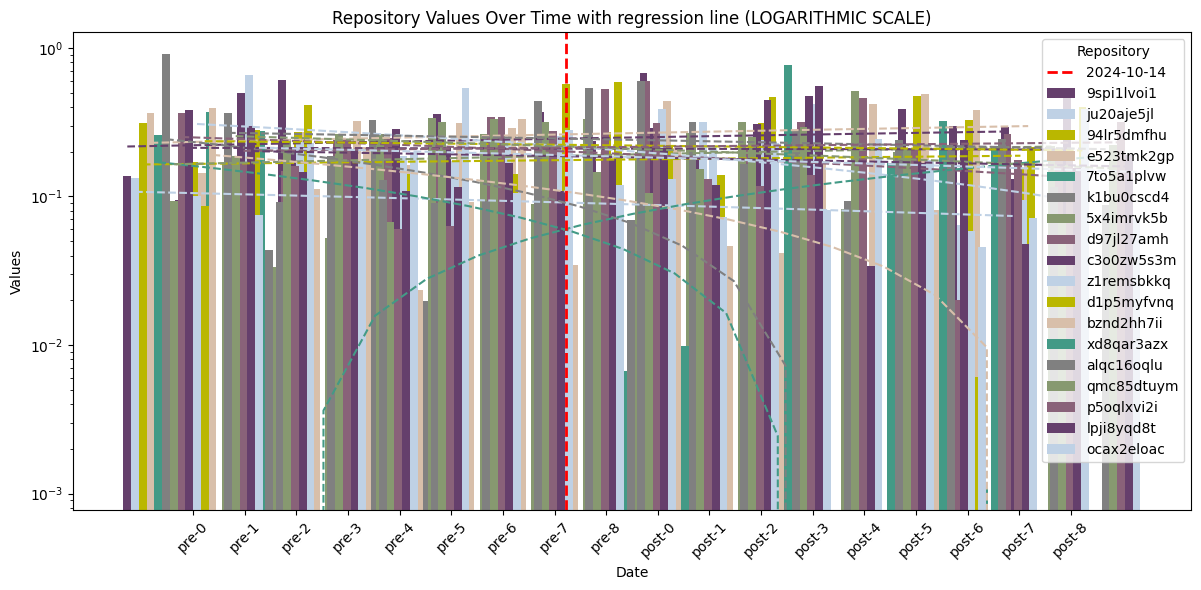

In [7]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in file_level_result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(file_level_result_df['repository']):
    # Extract data for the current repository
    values = file_level_result_df[file_level_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = file_level_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(file_level_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

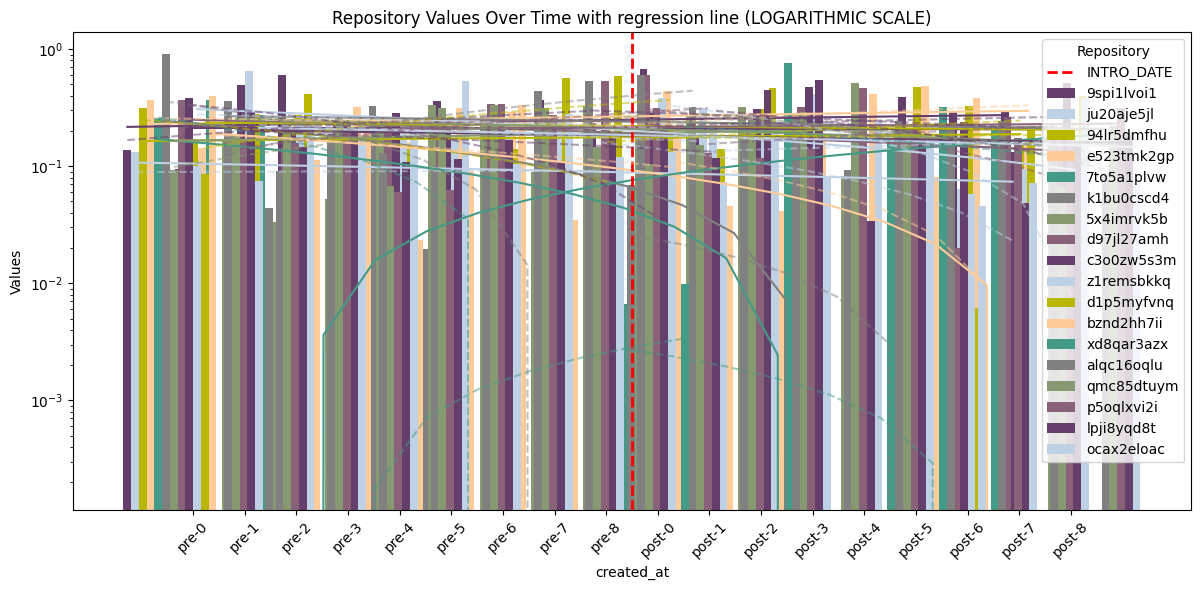

In [8]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in file_level_result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(file_level_result_df['repository']):
    # Extract data for the current repository
    values = file_level_result_df[file_level_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = file_level_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(file_level_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(file_level_result_df['repository']):
    values = file_level_result_df[file_level_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(file_level_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

# Significancetest 

In [9]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the file_level_result_df
file_level_result_df = file_level_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in file_level_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in file_level_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(file_level_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

    repository  pre_p_value  after_p_value  pre_normal  after_normal
0   P3     0.018330   3.880230e-01       False          True
1   P9     0.301903   8.629353e-03        True         False
2   P2     0.602943   5.829097e-01        True          True
3   P8     0.423489   1.060277e-01        True          True
4   P1     0.000935   5.077477e-05       False         False
5   k1bu0cscd4     0.000040   3.217493e-07       False         False
6   5x4imrvk5b     0.195144   8.092338e-01        True          True
7   P7     0.563861   1.876626e-01        True          True
8   P5     0.089795   6.133734e-01        True          True
9   P14     0.006086   1.075777e-01       False          True
10  P6     0.150138   3.173438e-01        True          True
11  bznd2hh7ii     0.082367   9.852048e-04        True         False
12  xd8qar3azx     1.000000   2.839614e-03        True         False
13  P4     0.068523   4.537153e-01        True          True
14  P13     0.383228   4.509932e-01        T

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [10]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, file_level_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)
from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(file_level_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P3  Cliff's Delta     0.135802 -0.456790  0.679012
1   P9  Cliff's Delta    -0.185185 -0.728395  0.407407
2   P2  Cliff's Delta     0.209877 -0.358642  0.703704
3   P8  Cliff's Delta     0.160494 -0.408025  0.703704
4   P1  Cliff's Delta    -0.827160 -1.000000 -0.481481
5   k1bu0cscd4  Cliff's Delta    -0.333333 -0.666975  0.037037
6   5x4imrvk5b  Cliff's Delta     0.111111 -0.432099  0.679630
7   P7  Cliff's Delta    -0.086420 -0.654321  0.456790
8   P5  Cliff's Delta     0.259259 -0.296296  0.777778
9   P14  Cliff's Delta    -0.283951 -0.802469  0.234568
10  P6  Cliff's Delta    -0.259259 -0.753086  0.259259
11  bznd2hh7ii  Cliff's Delta    -0.432099 -0.864506  0.111111
12  xd8qar3azx  Cliff's Delta     0.555556  0.222222  0.888889
13  P4  Cliff's Delta    -0.160494 -0.679630  0.456790
14  P13  Cliff's Delta    -0.234568 -0.728395  0.309259
15  P12  Cliff's Delta    -0.185185 -0.729012  0.358642
16  P10  Cliff's Delta

In [11]:
merged = file_level_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,0.137596,0.095011,0.101964,0.605888,0.144463,0.096353,0.357395,0.180478,0.369830,...,0.130867,0.121191,0.000000,0.388987,0.297600,0.292652,Cliff's Delta,0.135802,-0.456790,0.679012
1,P9,0.132898,0.089866,0.044066,0.029131,0.130173,0.104406,0.150311,0.003317,0.122795,...,0.103019,0.045552,0.000000,0.048833,0.064431,0.036515,Cliff's Delta,-0.185185,-0.728395,0.407407
2,P2,0.314287,0.171360,0.231248,0.271543,0.111334,0.181225,0.000000,0.058877,0.000000,...,0.309687,0.076091,0.012956,0.475418,0.324572,0.153597,Cliff's Delta,0.209877,-0.358642,0.703704
3,P8,0.365171,0.143909,0.164557,0.270488,0.323019,0.162403,0.313055,0.288025,0.220445,...,0.168570,0.173950,0.417621,0.486879,0.382478,0.162514,Cliff's Delta,0.160494,-0.408025,0.703704
4,P1,0.257230,0.368801,0.276202,0.001289,0.001267,0.004811,0.001206,0.001182,0.001161,...,0.000000,0.000000,0.000000,0.001109,0.001087,0.000000,Cliff's Delta,-0.827160,-1.000000,-0.481481
5,k1bu0cscd4,0.908333,0.000000,0.043870,0.000000,0.326474,0.019735,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Cliff's Delta,-0.333333,-0.666975,0.037037
6,5x4imrvk5b,0.092896,0.167056,0.033246,0.052472,0.262419,0.336477,0.264509,0.088836,0.329884,...,0.246879,0.081864,0.199801,0.171867,0.098015,0.219658,Cliff's Delta,0.111111,-0.432099,0.679630
7,P7,0.366153,0.157419,0.147150,0.238694,0.248139,0.226732,0.342589,0.021573,0.000000,...,0.319119,0.079538,0.002657,0.020035,0.262620,0.186028,Cliff's Delta,-0.086420,-0.654321,0.456790
8,P5,0.382781,0.497560,0.207143,0.000000,0.282906,0.211804,0.000000,0.000000,0.000000,...,0.476368,0.103262,0.000000,0.240278,0.131176,0.518648,Cliff's Delta,0.259259,-0.296296,0.777778
9,P14,0.101066,0.655280,0.233275,0.144587,0.188505,0.173065,0.248677,0.253477,0.063831,...,0.416087,0.020429,0.079743,0.058243,0.094300,0.033747,Cliff's Delta,-0.283951,-0.802469,0.234568


In [12]:
merged = file_level_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,0.137596,0.095011,0.101964,0.605888,0.144463,0.096353,0.357395,0.180478,0.369830,...,0.130867,0.121191,0.000000,0.388987,0.297600,0.292652,Cliff's Delta,0.135802,-0.456790,0.679012
1,P9,0.132898,0.089866,0.044066,0.029131,0.130173,0.104406,0.150311,0.003317,0.122795,...,0.103019,0.045552,0.000000,0.048833,0.064431,0.036515,Cliff's Delta,-0.185185,-0.728395,0.407407
2,P2,0.314287,0.171360,0.231248,0.271543,0.111334,0.181225,0.000000,0.058877,0.000000,...,0.309687,0.076091,0.012956,0.475418,0.324572,0.153597,Cliff's Delta,0.209877,-0.358642,0.703704
3,P8,0.365171,0.143909,0.164557,0.270488,0.323019,0.162403,0.313055,0.288025,0.220445,...,0.168570,0.173950,0.417621,0.486879,0.382478,0.162514,Cliff's Delta,0.160494,-0.408025,0.703704
4,P1,0.257230,0.368801,0.276202,0.001289,0.001267,0.004811,0.001206,0.001182,0.001161,...,0.000000,0.000000,0.000000,0.001109,0.001087,0.000000,Cliff's Delta,-0.827160,-1.000000,-0.481481
5,k1bu0cscd4,0.908333,0.000000,0.043870,0.000000,0.326474,0.019735,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Cliff's Delta,-0.333333,-0.666975,0.037037
6,5x4imrvk5b,0.092896,0.167056,0.033246,0.052472,0.262419,0.336477,0.264509,0.088836,0.329884,...,0.246879,0.081864,0.199801,0.171867,0.098015,0.219658,Cliff's Delta,0.111111,-0.432099,0.679630
7,P7,0.366153,0.157419,0.147150,0.238694,0.248139,0.226732,0.342589,0.021573,0.000000,...,0.319119,0.079538,0.002657,0.020035,0.262620,0.186028,Cliff's Delta,-0.086420,-0.654321,0.456790
8,P5,0.382781,0.497560,0.207143,0.000000,0.282906,0.211804,0.000000,0.000000,0.000000,...,0.476368,0.103262,0.000000,0.240278,0.131176,0.518648,Cliff's Delta,0.259259,-0.296296,0.777778
9,P14,0.101066,0.655280,0.233275,0.144587,0.188505,0.173065,0.248677,0.253477,0.063831,...,0.416087,0.020429,0.079743,0.058243,0.094300,0.033747,Cliff's Delta,-0.283951,-0.802469,0.234568


# Interpretation
- bootstrap NR
- react-native -> signifikant höhere M1
- vue -> signifikant niedrigere M1
- fastapi NR
- godot NR